In [115]:
import os, sys, gzip
import cPickle as pickle
sys.setrecursionlimit(10000)

import numpy as np
np.random.seed(1004)   # for reproducibility
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
%matplotlib inline
from scipy.misc import imresize
import pandas as pd

from lasagne import layers, nonlinearities, updates, objectives, init 
from lasagne.layers import get_output, get_output_shape, get_all_params
from lasagne.layers import Conv2DLayer, TransposedConv2DLayer, DenseLayer, InputLayer, ExpressionLayer, BiasLayer
import theano.tensor as T
import theano
#from theano.sandbox.rng_mrg import MRG_RandomStreams as RandomStreams
from theano.tensor.shared_randomstreams import RandomStreams

sys.path.append('..')
from src import make_directory 
from data import load_data

In [133]:
name = 'MotifSimulation_binary'
datapath = '/home/peter/Data/SequenceMotif'
filepath = os.path.join(datapath, 'N=300000_S=200_M=20_G=20_data.pickle')
train, valid, test = load_data(name, filepath)
shape = (None, train[0].shape[1], train[0].shape[2], train[0].shape[3])
num_labels = train[1].shape[1]

X_train = train[0]
y_train = np.argmax(train[1],axis=1)
X_valid = valid[0]
y_valid = np.argmax(valid[1],axis=1)
X_test = test[0]
y_test = np.argmax(test[1],axis=1)

loading data from: /home/peter/Data/SequenceMotif/N=300000_S=200_M=20_G=20_data.pickle
loading train data
loading cross-validation data
loading test data


In [125]:
class VariationalSampleLayer(layers.MergeLayer):
    def __init__(self, incoming_mu, incoming_logsigma, **kwargs):
        super(VariationalSampleLayer, self).__init__(incomings=[incoming_mu, incoming_logsigma], **kwargs)
        self.srng = RandomStreams(seed=234)

    def get_output_shape_for(self, input_shapes):
        return input_shapes[0]

    def get_output_for(self, inputs, deterministic=False, **kwargs):
        mu, logsigma = inputs
        shape=(self.input_shapes[0][0] or inputs[0].shape[0],
                self.input_shapes[0][1] or inputs[0].shape[1])
        if deterministic:
            return mu
        return mu + T.exp(logsigma) * self.srng.normal(shape, avg=0.0, std=1).astype(theano.config.floatX)


In [147]:
net['dense2'].input_shape[1]

200

In [148]:
num_encode=20

input_var = T.tensor4('inputs')
net = {}
net['input'] = layers.InputLayer(shape=shape, input_var=input_var)
net['conv1'] = layers.Conv2DLayer(net['input'],  num_filters=20,
                                  filter_size=(15,1),
                                  W=init.GlorotUniform(),
                                  b=None, 
                                  pad='same')

net['conv1_bias'] = layers.BiasLayer(net['conv1'], b=init.Constant(0.05))
net['conv1_norm'] = layers.BatchNormLayer(net['conv1_bias'])
net['conv1_active'] = layers.NonlinearityLayer(net['conv1_norm'],nonlinearity=nonlinearities.rectify) 
net['conv1_pool'] = layers.MaxPool2DLayer(net['conv1_active'], pool_size=(4,1))

net['conv2'] = layers.Conv2DLayer(net['conv1_pool'],  num_filters=40,
                                  filter_size=(9,1),
                                  W=init.GlorotUniform(),
                                  b=None, 
                                  pad='same')
net['conv2_bias'] = layers.BiasLayer(net['conv2'], b=init.Constant(0.05))
net['conv2_norm'] = layers.BatchNormLayer(net['conv2_bias'])
net['conv2_active'] = layers.NonlinearityLayer(net['conv2_norm'],nonlinearity=nonlinearities.rectify)                          
net['conv2_pool'] = layers.MaxPool2DLayer(net['conv2_active'], pool_size=(2,1))
                                            

net['dense1'] = layers.DenseLayer(net['conv2_pool'], num_units=200, W=init.GlorotUniform(), 
                                  b=init.Constant(.0), nonlinearity=nonlinearities.rectify)
net['dense2'] = layers.DenseLayer(net['dense1'], num_units=100, W=init.GlorotUniform(), 
                                  b=init.Constant(.0), nonlinearity=nonlinearities.rectify)
                                  
net['encode_mu'] = layers.DenseLayer(net['dense2'], num_units=num_encode, W=init.GlorotUniform(), 
                                  b=init.Constant(.0), nonlinearity=nonlinearities.linear)
net['encode_logsigma'] = layers.DenseLayer(net['dense2'], num_units=num_encode, W=init.GlorotUniform(), 
                                  b=init.Constant(.0), nonlinearity=nonlinearities.linear)
net['Z'] = VariationalSampleLayer(net['encode_mu'], net['encode_logsigma'])
                                  
net['invline'] = layers.DenseLayer(net['Z'], num_units=net['dense2'].output_shape[1], W=init.GlorotUniform(), 
                                  b=init.Constant(.0), nonlinearity=nonlinearities.linear)
net['invdense2'] = layers.DenseLayer(net['invline'], num_units=net['dense2'].input_shape[1], W=net['dense2'].W.dimshuffle([1,0]), 
                                  b=init.Constant(.0), nonlinearity=nonlinearities.rectify)
num_units = np.prod(list(net['dense1'].input_shape)[1:])
net['invdense1'] = layers.DenseLayer(net['invdense2'], num_units=num_units, W=net['dense1'].W.dimshuffle([1,0]), 
                                  b=init.Constant(.0), nonlinearity=nonlinearities.rectify)
shape2 = list(get_output_shape(net['conv2_pool']))
shape2[0] = -1
net['reshape'] = layers.ReshapeLayer(net['invdense1'], shape=tuple(shape2))

net['invpool2'] = layers.Upscale2DLayer(net['reshape'], (2,1))
net['invconv2']  = Conv2DLayer(net['invpool2'], num_filters=net['conv2'].input_shape[1],
                                          filter_size=net['conv2'].filter_size,
                                          W=net['conv2'].W.dimshuffle([1,0,2,3]), #W2_inv, #
                                          b=init.Constant(0.05), 
                                          pad='same',
                                          nonlinearity=nonlinearities.rectify, flip_filters=True)


net['invpool1'] = layers.Upscale2DLayer(net['invconv2'], (4,1))
net['X']  = Conv2DLayer(net['invpool1'], num_filters=net['conv1'].input_shape[1],
                                          filter_size=net['conv1'].filter_size,
                                          W=net['conv1'].W.dimshuffle([1,0,2,3]), #W2_inv, #
                                          b=init.Constant(0.05), 
                                          pad='same',
                                          nonlinearity=nonlinearities.sigmoid, flip_filters=True)

In [149]:
def build_loss(net, target_var, deterministic):
    
    z_mu = get_output(net['encode_mu'], deterministic=deterministic)
    z_logsigma = get_output(net['encode_logsigma'], deterministic=deterministic)
    kl_divergence = 0.5*T.sum(1 + 2*z_logsigma - T.sqr(z_mu) - T.exp(2*z_logsigma), axis=1)
    
    x_mu = get_output(net['X'], deterministic=deterministic)
    x_mu = T.clip(x_mu, 1e-7, 1-1e-7)
    
    num_data = target_var.shape[0]
    target_var = target_var.reshape([num_data,-1])
    x_mu = x_mu.reshape([num_data, -1])
    log_likelihood = T.sum(target_var*T.log(1e-10+x_mu) + (1.0-target_var)*T.log(1e-10+1.0-x_mu), axis=1)
    variational_lower_bound = -log_likelihood - kl_divergence
    prediction = x_mu
    return variational_lower_bound.mean(), prediction

train_loss, train_prediction = build_loss(net, input_var, deterministic=False)

# ADAM updates
params = get_all_params(net['X'], trainable=True)
update_op = updates.adam(train_loss, params, learning_rate=1e-3)
train_fun = theano.function([input_var], train_loss, updates=update_op)

In [150]:
def batch_generator(X, batch_size=128, shuffle=True):
    if shuffle:
        indices = np.arange(len(X))
        np.random.shuffle(indices)
    for start_idx in range(0, len(X)-batch_size+1, batch_size):
        if shuffle:
            excerpt = indices[start_idx:start_idx+batch_size]
        else:
            excerpt = slice(start_idx, start_idx+batch_size)
        yield X[excerpt].astype(np.float32)
        
num_epochs = 60
batch_size = 100
num_train_batches = X_train.shape[0] // batch_size
    
for epoch in range(num_epochs):
    train_batches = batch_generator(X_train, batch_size, shuffle=True)

    train_loss = 0
    for index in range(num_train_batches):
        loss = train_fun(next(train_batches))
        train_loss += loss
        
    print("Epoch {} of {}".format(epoch+1, num_epochs))
    print("  training loss:\t\t{:.6f}".format(train_loss/num_train_batches))

Epoch 1 of 60
  training loss:		450.342891
Epoch 2 of 60
  training loss:		449.131445
Epoch 3 of 60
  training loss:		449.066858
Epoch 4 of 60
  training loss:		449.041328
Epoch 5 of 60
  training loss:		449.027942
Epoch 6 of 60
  training loss:		449.017469
Epoch 7 of 60
  training loss:		449.010655
Epoch 8 of 60
  training loss:		449.004963


KeyboardInterrupt: 

In [134]:

def seq_logo(pwm, height=100, width=200, norm=0, rna=1, filepath='.'):
    """generate a sequence logo from a pwm"""
    
    def load_alphabet(filepath, rna):
        """load images of nucleotide alphabet """
        df = pd.read_table(os.path.join(filepath, 'A.txt'), header=None);
        A_img = df.as_matrix()
        A_img = np.reshape(A_img, [72, 65, 3], order="F").astype(np.uint8)

        df = pd.read_table(os.path.join(filepath, 'C.txt'), header=None);
        C_img = df.as_matrix()
        C_img = np.reshape(C_img, [76, 64, 3], order="F").astype(np.uint8)

        df = pd.read_table(os.path.join(filepath, 'G.txt'), header=None);
        G_img = df.as_matrix()
        G_img = np.reshape(G_img, [76, 67, 3], order="F").astype(np.uint8)

        if rna == 1:
            df = pd.read_table(os.path.join(filepath, 'U.txt'), header=None);
            T_img = df.as_matrix()
            T_img = np.reshape(T_img, [74, 57, 3], order="F").astype(np.uint8)
        else:
            df = pd.read_table(os.path.join(filepath, 'T.txt'), header=None);
            T_img = df.as_matrix()
            T_img = np.reshape(T_img, [72, 59, 3], order="F").astype(np.uint8)

        return A_img, C_img, G_img, T_img


    def get_nt_height(pwm, height, norm):
        """get the heights of each nucleotide"""

        def entropy(p):
            """calculate entropy of each nucleotide"""
            s = 0
            for i in range(4):
                if p[i] > 0:
                    s -= p[i]*np.log2(p[i])
            return s

        num_nt, num_seq = pwm.shape
        heights = np.zeros((num_nt,num_seq));
        for i in range(num_seq):
            if norm == 1:
                total_height = height
            else:
                total_height = (np.log2(4) - entropy(pwm[:, i]))*height;
            heights[:,i] = np.floor(pwm[:,i]*total_height);
            
        return heights.astype(int)

    
    # get the alphabet images of each nucleotide
    A_img, C_img, G_img, T_img = load_alphabet(filepath='.', rna=1)
    
    
    # get the heights of each nucleotide
    heights = get_nt_height(pwm, height, norm)

    # resize nucleotide images for each base of sequence and stack
    num_nt, num_seq = pwm.shape
    nt_width = np.floor(width/num_seq).astype(int)
    logo = np.ones((height, width, 3)).astype(int)*255;
    for i in range(num_seq):
        remaining_height = height;
        nt_height = np.sort(heights[:,i]);
        index = np.argsort(heights[:,i])

        
        for j in range(num_nt):
            # resized dimensions of image
            if nt_height[j] > 0:
                resize = (nt_height[j],nt_width)
                if index[j] == 0:
                    nt_img = imresize(A_img, resize)
                elif index[j] == 1:
                    nt_img = imresize(C_img, resize)
                elif index[j] == 2:
                    nt_img = imresize(G_img, resize)
                elif index[j] == 3:
                    nt_img = imresize(T_img, resize)

                # determine location of image
                height_range = range(remaining_height-nt_height[j], remaining_height)
                width_range = range(i*nt_width, i*nt_width+nt_width)

                # 'annoying' way to broadcast resized nucleotide image
                for k in range(3):
                    for m in range(len(width_range)):
                        logo[height_range, width_range[m],k] = nt_img[:,m,k];

                remaining_height -= nt_height[j]

    return logo.astype(np.uint8)


def plot_conv_filter(plt, pwm, height=200, bp_width=100, norm=0, rna=1, adjust=-1, filepath='.', showbar=0):
    num_seq = pwm.shape[1]
    width = bp_width*num_seq

    logo = seq_logo(pwm, height, width, norm, rna, filepath)
    
    fig, axes = plt.subplots(nrows=2, ncols=1)
    axes[0].imshow(logo, extent=[bp_width*2, width+bp_width, 0, height])
    axes[0].set_axis_off()
    im = axes[1].imshow(pwm, cmap='jet', vmin=0, vmax=1, interpolation='none') 
    axes[1].set_axis_off()
    fig.subplots_adjust(bottom=adjust)
    if showbar == 1:
        cbar_ax = fig.add_axes([.85, 0.05, 0.05, 0.45])
        cb = fig.colorbar(im, cax=cbar_ax, ticks=[0, 0.5, 1])
        cb.ax.tick_params(labelsize=16)
    return fig

def fig_options(plt, options):
    if 'figsize' in options:
        fig = plt.gcf()
        fig.set_size_inches(options['figsize'][0], options['figsize'][1], forward=True)
    if 'ylim' in options:
        plt.ylim(options['ylim'][0],options['ylim'][1])
    if 'yticks' in options:
        plt.yticks(options['yticks'])
    if 'xticks' in options:
        plt.xticks(options['xticks'])
    if 'labelsize' in options:        
        ax = plt.gca()
        ax.tick_params(axis='x', labelsize=options['labelsize'])
        ax.tick_params(axis='y', labelsize=options['labelsize'])
    if 'axis' in options:
        plt.axis(options['axis'])
    if 'xlabel' in options:
        plt.xlabel(options['xlabel'], fontsize=options['fontsize'])
    if 'ylabel' in options:
        plt.ylabel(options['ylabel'], fontsize=options['fontsize'])
    if 'linewidth' in options:
        plt.rc('axes', linewidth=options['linewidth'])
        

def subplot_grid(nrows, ncols):
    grid= mpl.gridspec.GridSpec(nrows, ncols)
    grid.update(wspace=0.2, hspace=0.2, left=0.1, right=0.2, bottom=0.1, top=0.2) 
    return grid


def get_weights(layer, convert_pwm=0):
    W =  np.squeeze(layer.W.get_value())
    W_norm = W
    if convert_pwm == 1:
        for i in range(len(W)):
            #weights = np.exp(W[i])
            MIN = np.min(W[i])
            weights = W[i] - MIN
            Z = np.sum(weights, axis=0)
            weights /= np.tile(Z, (W[i].shape[0],1))
            W_norm[i] = weights
    return W_norm

def plot_conv_weights(W, options):
    num_filters = W.shape[0]
    nrows = np.ceil(np.sqrt(num_filters)).astype(int)
    ncols = nrows
    plt.figure()
    grid = subplot_grid(nrows, ncols)
    for i in range(num_filters):
        plt.subplot(grid[i])
        plt.imshow(W[i], cmap='hot_r', interpolation='nearest')
        fig_options(plt, options)
    return plt


In [139]:
#X2, labels = reconstruct_layer2(network, train)
map_index = range(10000)
X = train[0][map_index]
X = np.expand_dims(X,0)
y = np.argmax(train[1][map_index])

def get_class_pwm(X, class_index, norm=0):
    class_pwm = 0
    for i in class_index:
        x = np.squeeze(X[i])
        if norm == 1:
            for i in range(5):
                x[:,:10]=0
                x[:,-10:]=0
                MEAN = np.nanmean(x,axis=1)
                x -= np.outer(MEAN, np.ones(x.shape[1]))
            sumX = np.sum(x,axis=0)
            x /= np.outer(np.ones(4),sumX)
        class_pwm += x
    class_pwm /= len(class_index)
    return class_pwm

model = []
for class_plot in range(20):
    y = np.argmax(train[1], axis=1)
    y = y[map_index]
    class_index = np.where(y == class_plot)[0]
    model.append(get_class_pwm(np.squeeze(X), class_index))


/home/peter/anaconda2/lib/python2.7/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


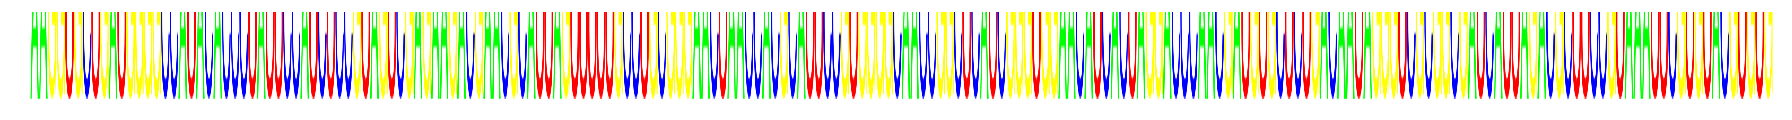

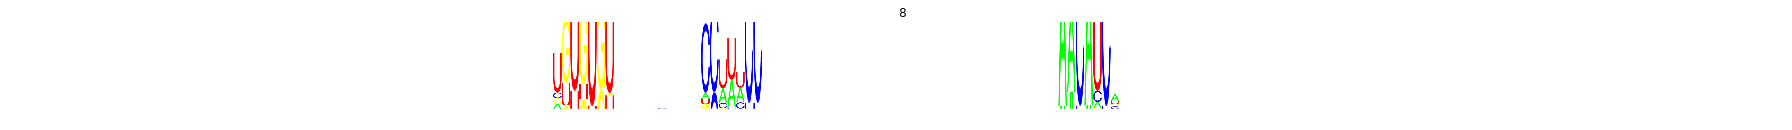

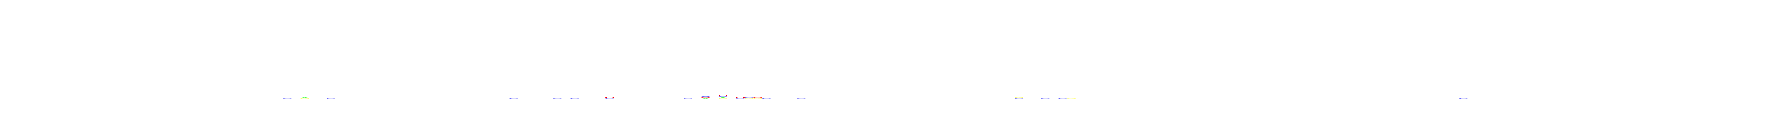

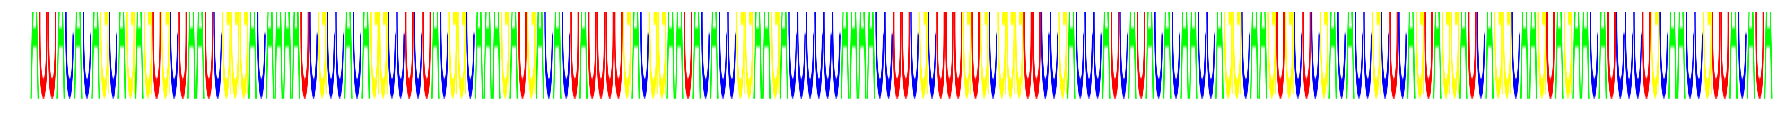

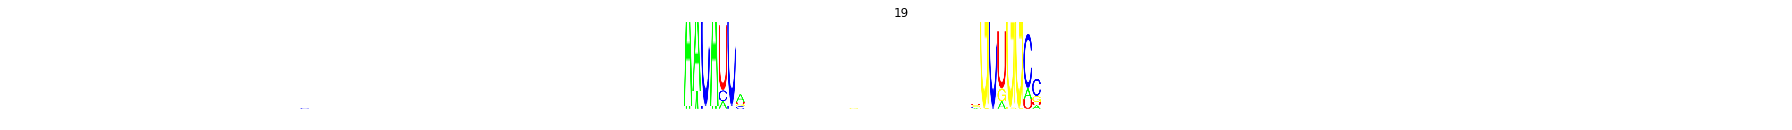

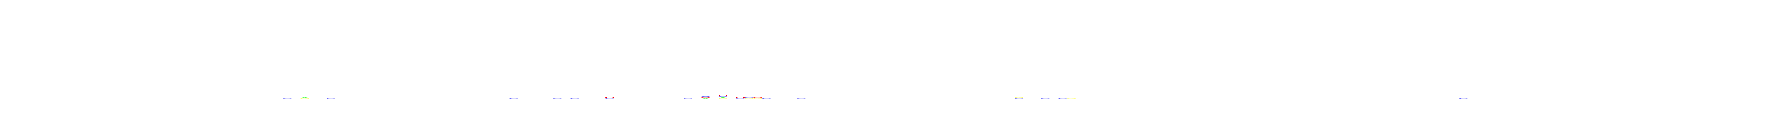

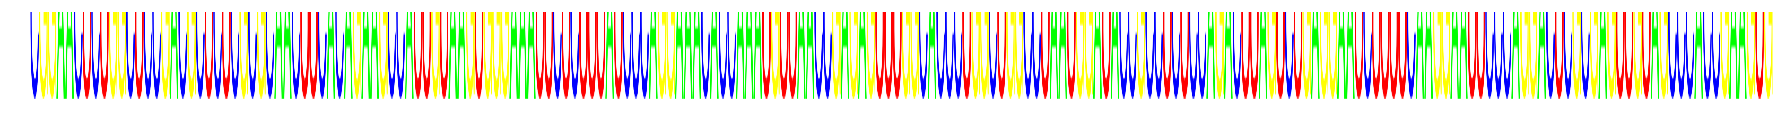

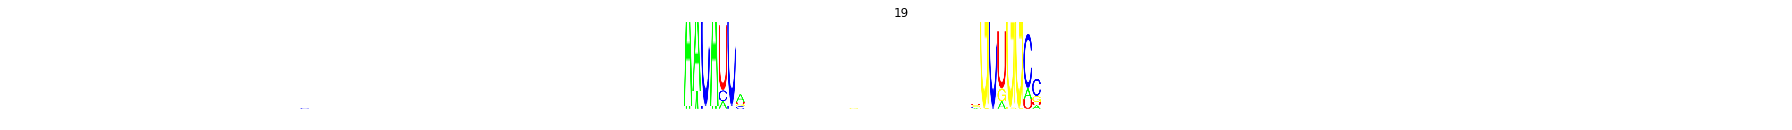

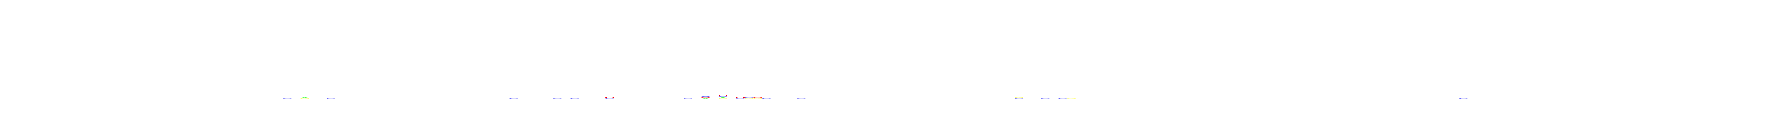

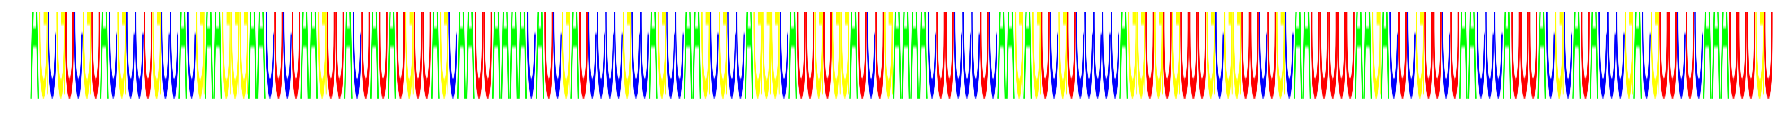

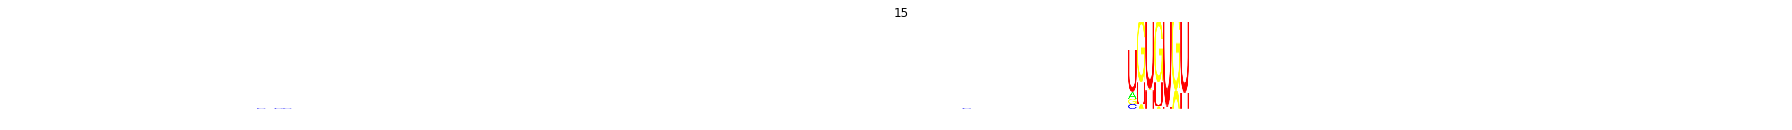

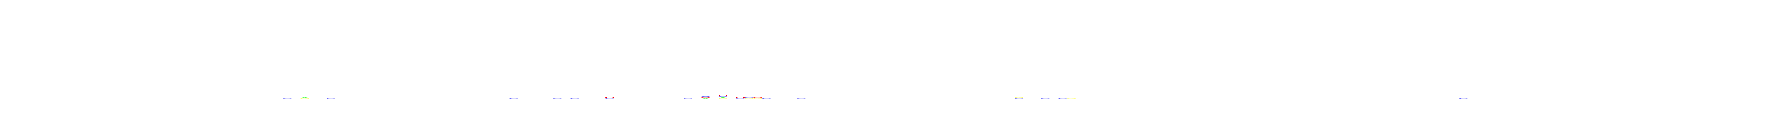

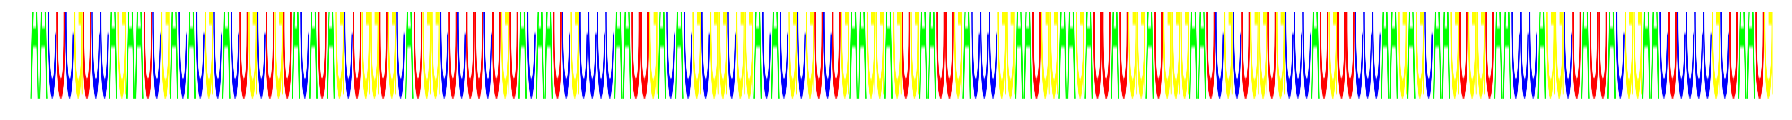

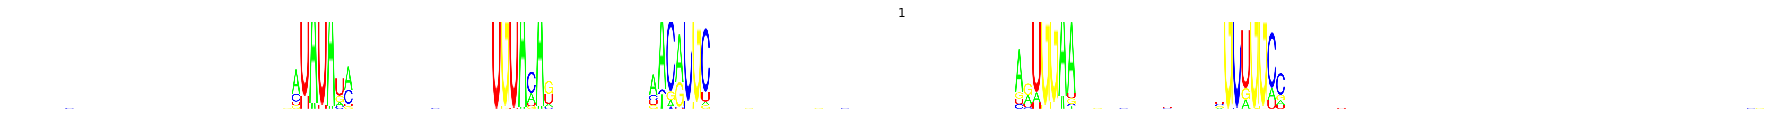

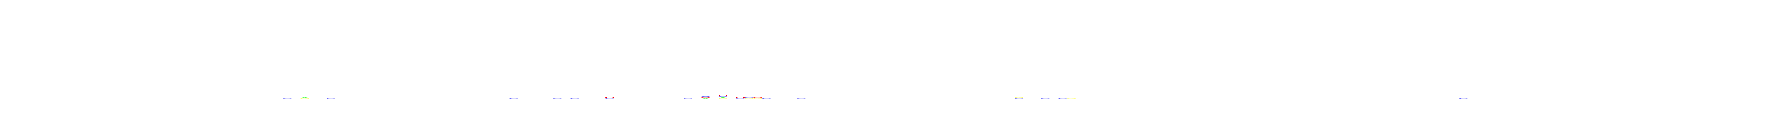

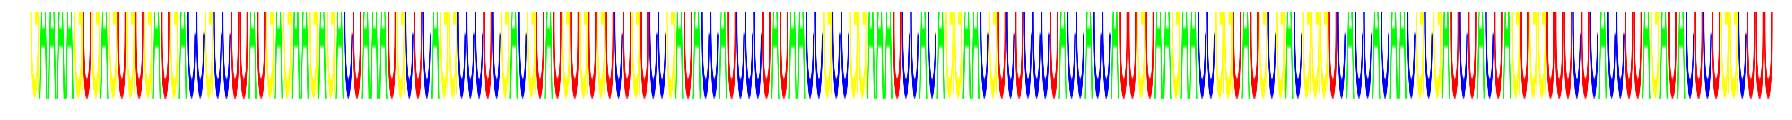

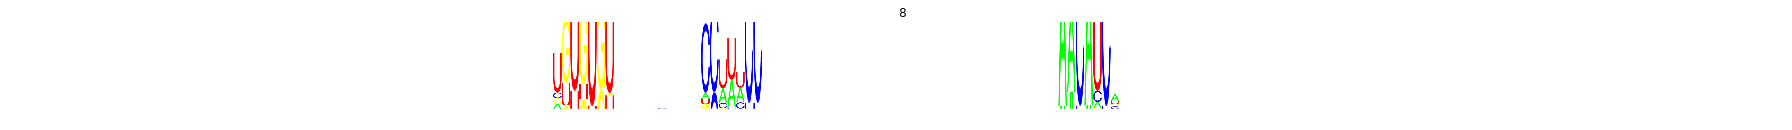

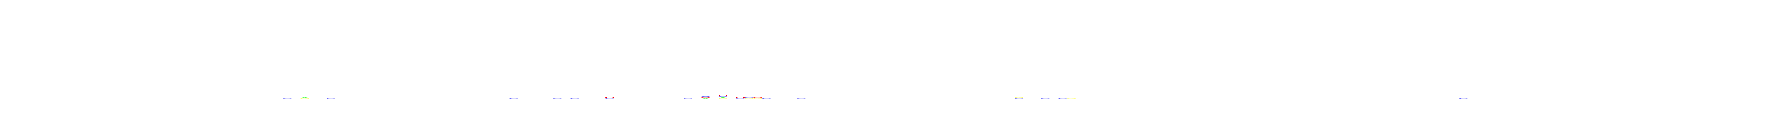

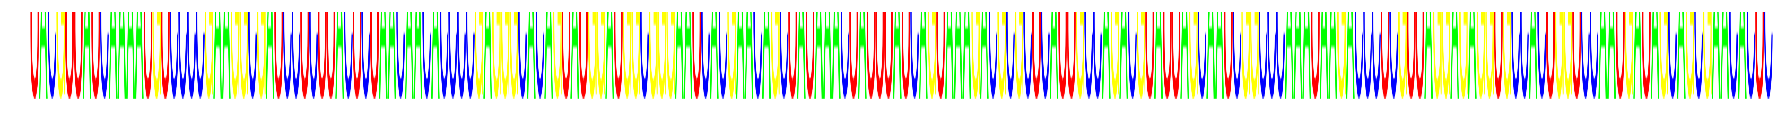

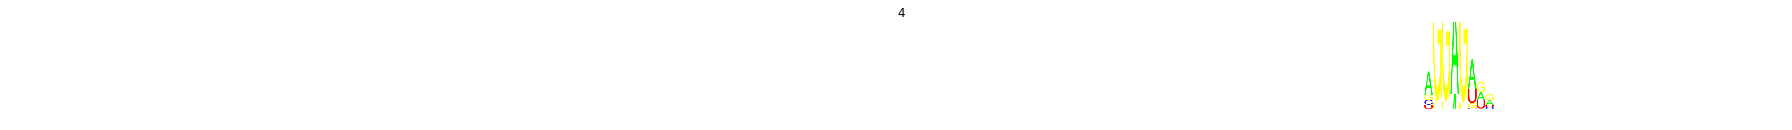

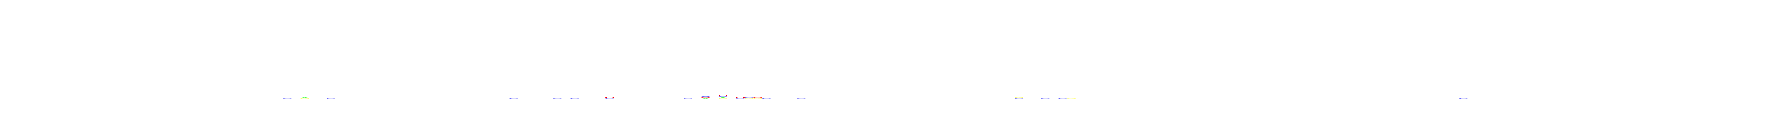

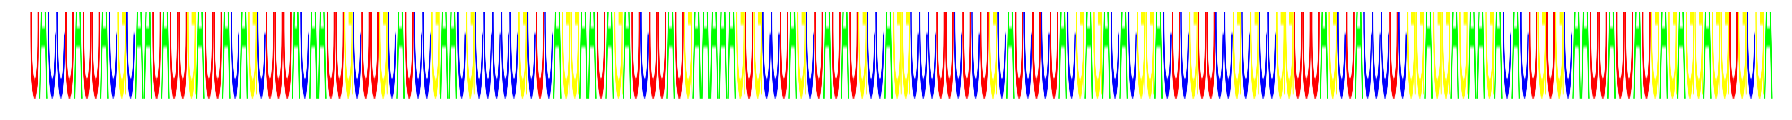

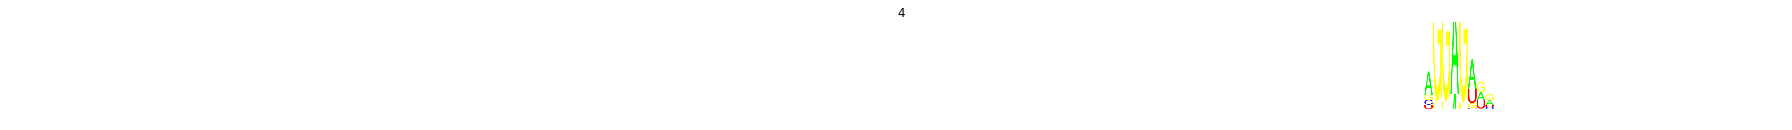

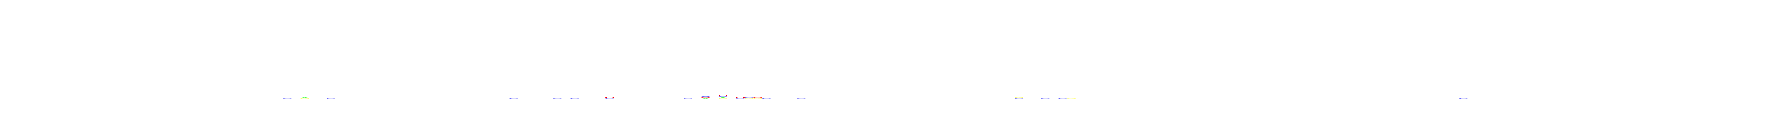

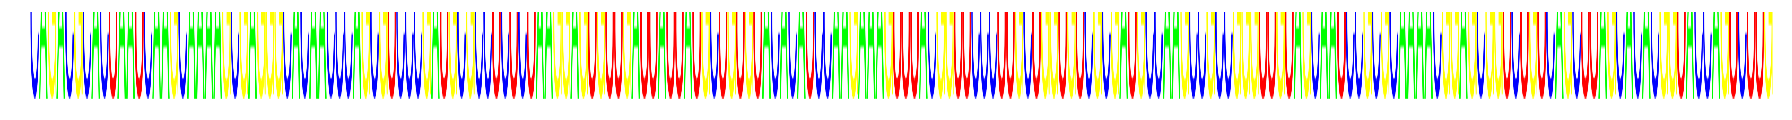

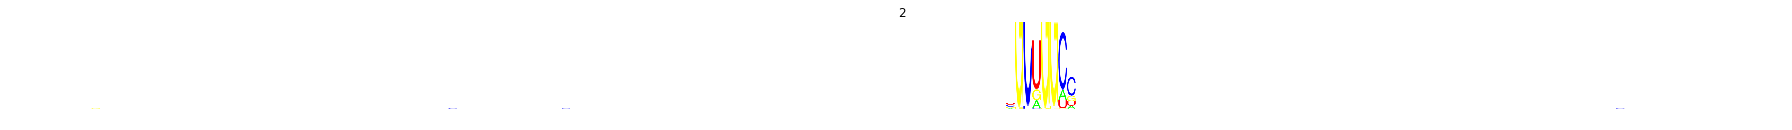

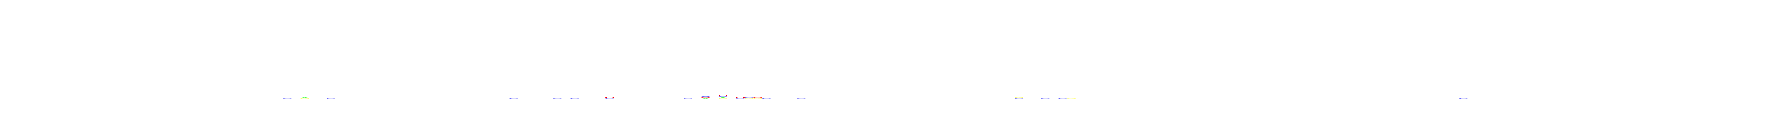

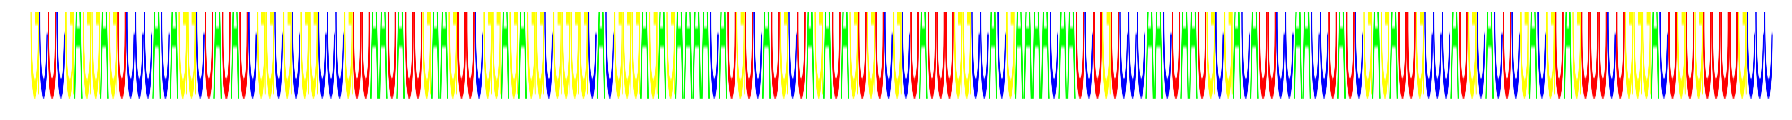

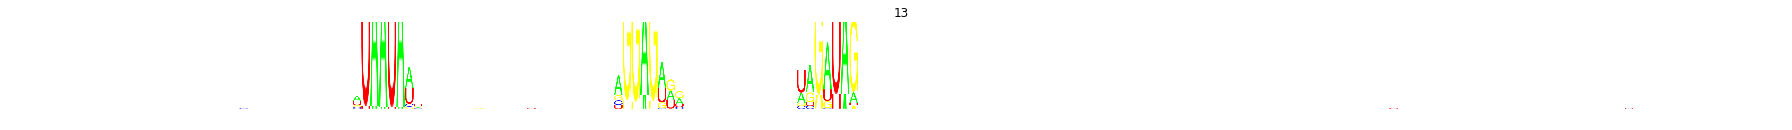

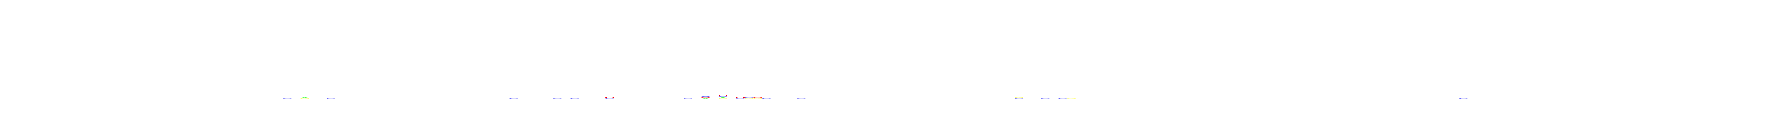

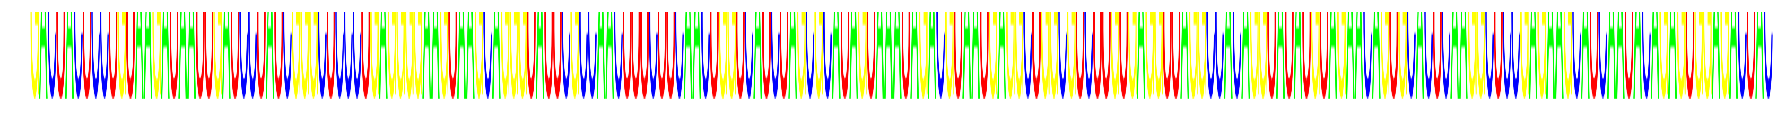

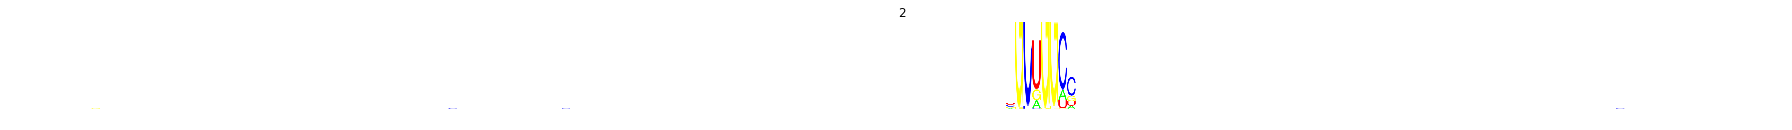

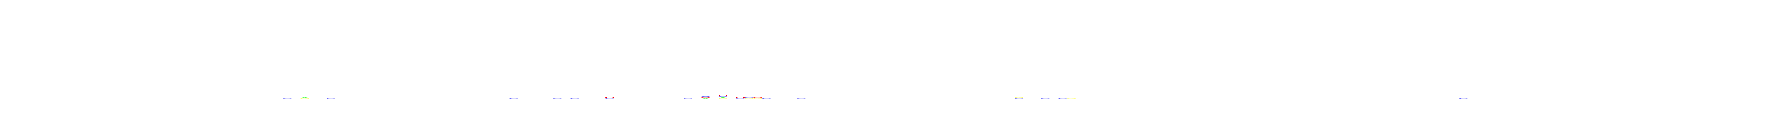

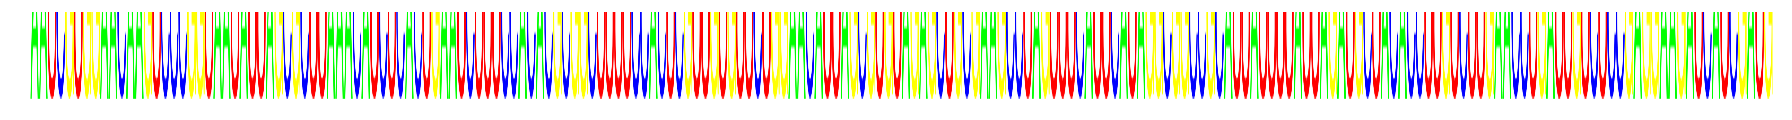

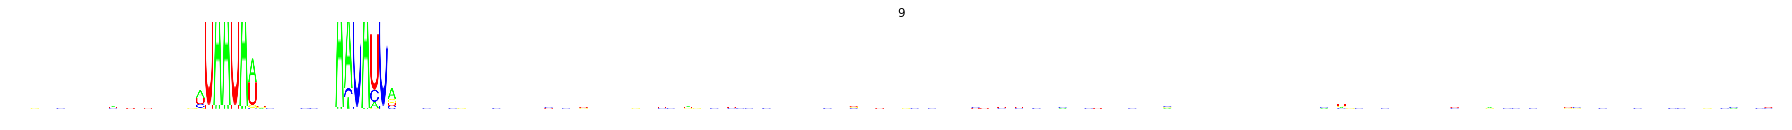

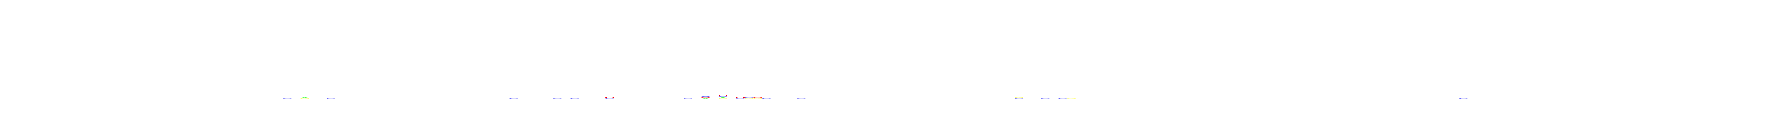

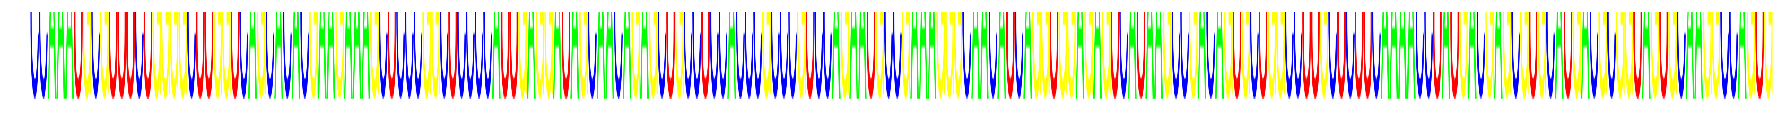

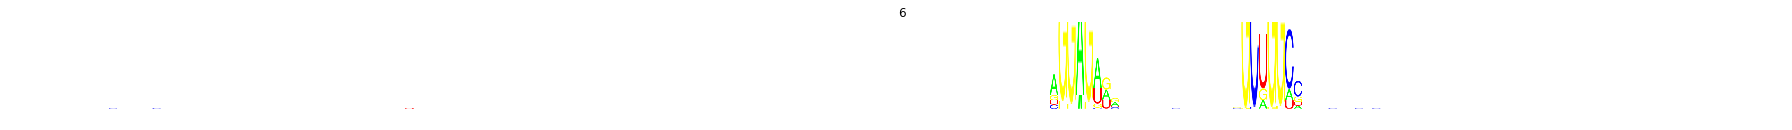

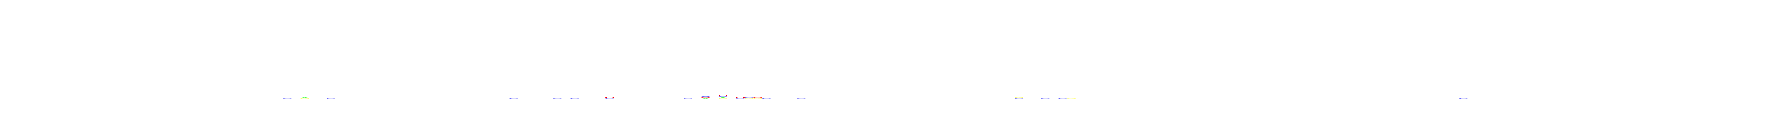

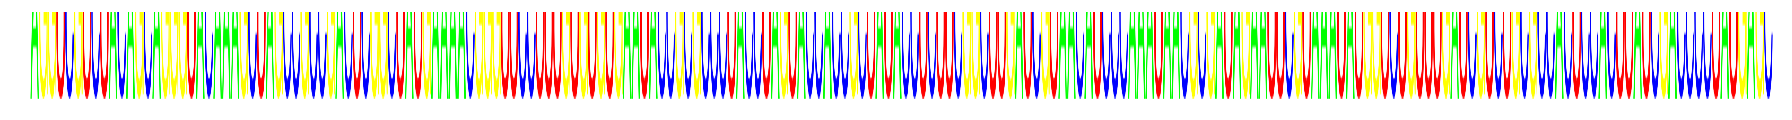

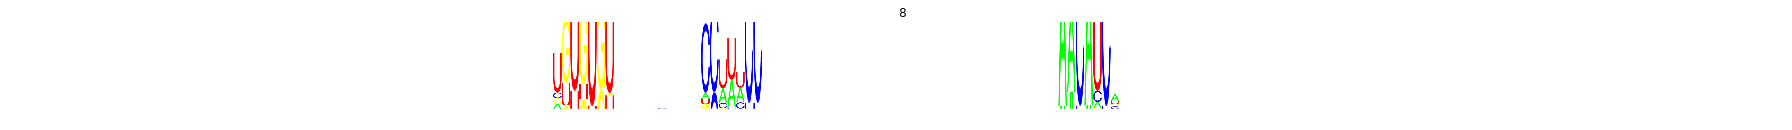

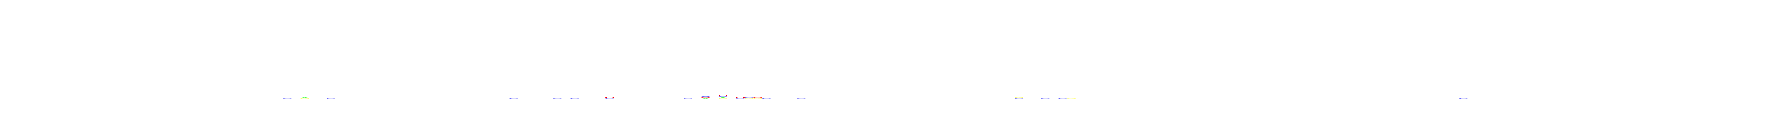

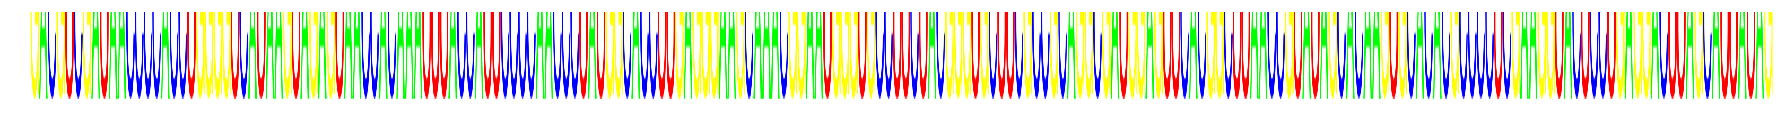

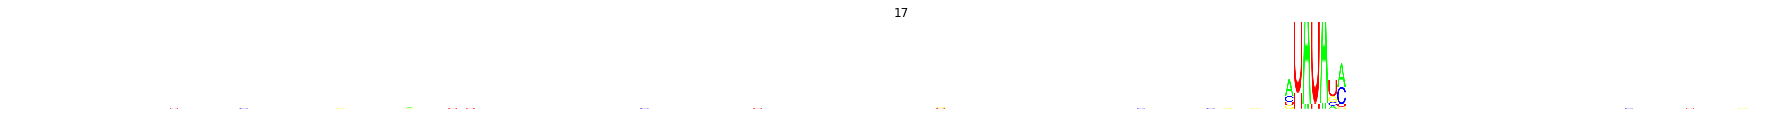

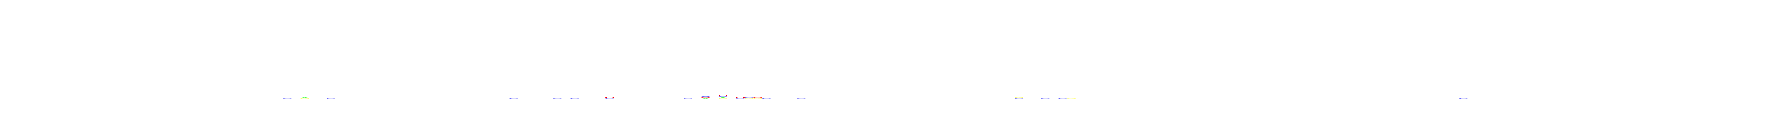

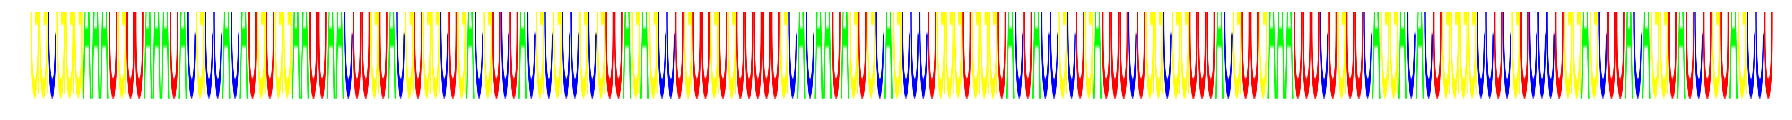

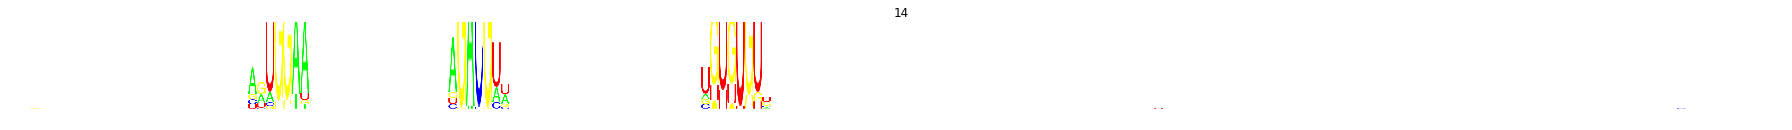

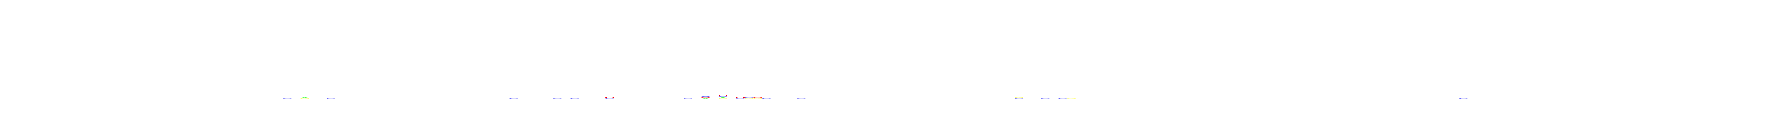

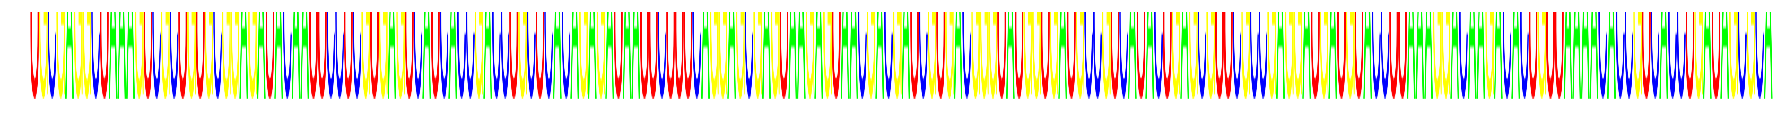

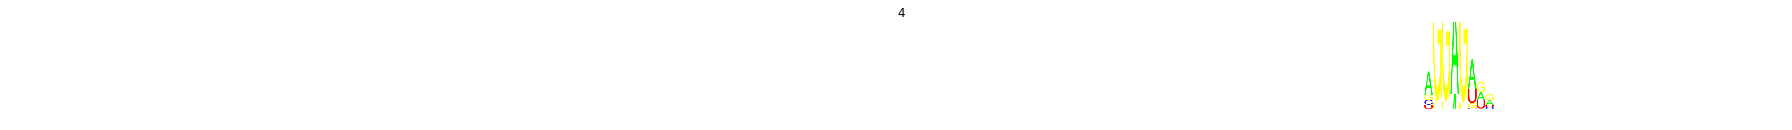

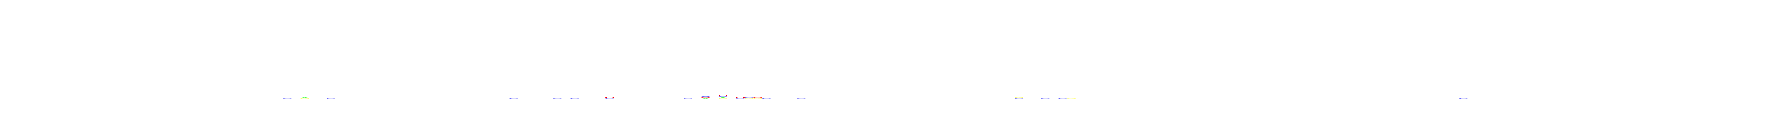

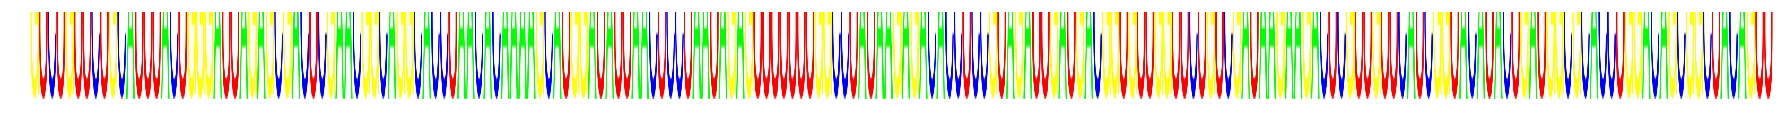

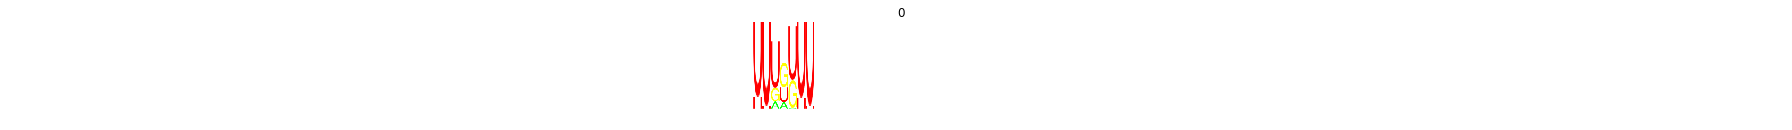

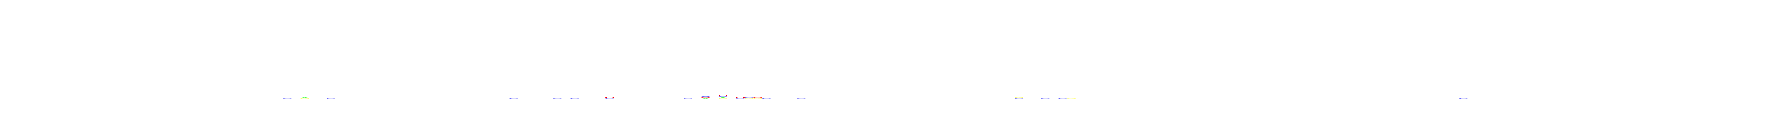

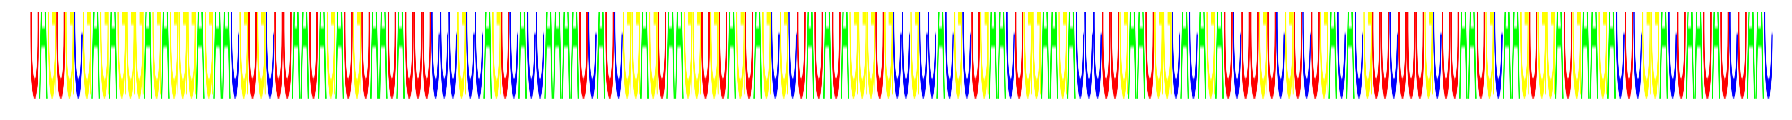

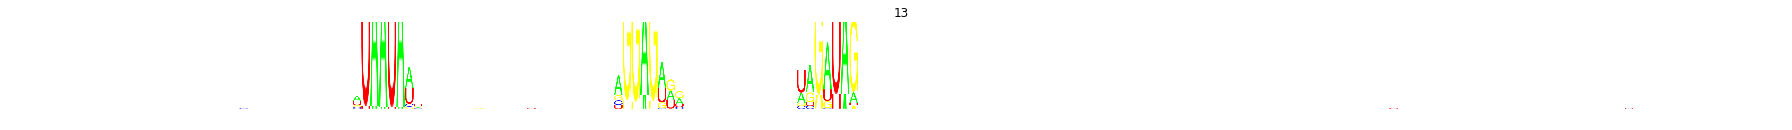

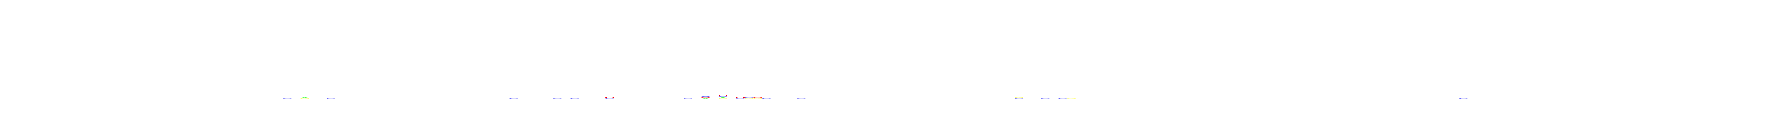

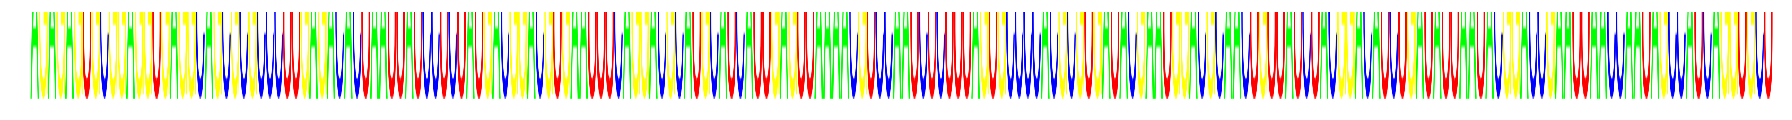

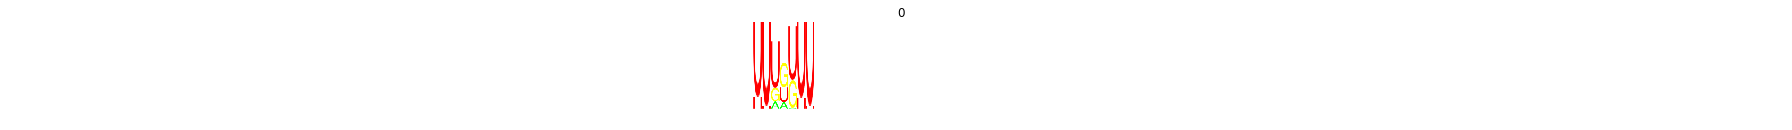

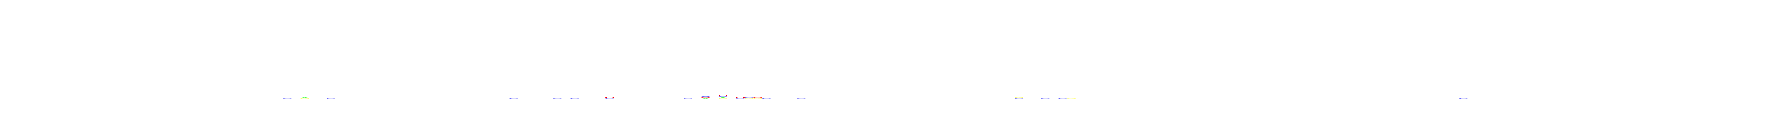

In [140]:
# save some example pictures so we can see what it's done 
prediction = theano.function([input_var], get_output(net['X'], deterministic=True))

for index in range(270,290):
    
    prediction = pred_fn(np.expand_dims(X_test[index],0).astype(np.float32))
    class_index = y_test[index]
    

    height=300
    bp_width=30
    num_seq = prediction.shape[2]
    width = bp_width*num_seq
    size = (25.,25.0)

    logo = seq_logo(np.squeeze(test[0][index]), height, width, norm=0, rna=1, filepath='.')
    fig = plt.figure(figsize=size);
    plt.imshow(logo, interpolation='none');
    plt.axis('off');

    logo = seq_logo(np.squeeze(model[class_index]), height, width, norm=0, rna=1, filepath='.')
    fig = plt.figure(figsize=size);
    plt.imshow(logo, interpolation='none');
    plt.axis('off');
    plt.title(str(class_index))

    logo = seq_logo(np.squeeze(prediction[0]), height, width, norm=0, rna=1, filepath='.')
    fig = plt.figure(figsize=size);
    plt.imshow(logo, interpolation='none');
    plt.axis('off');


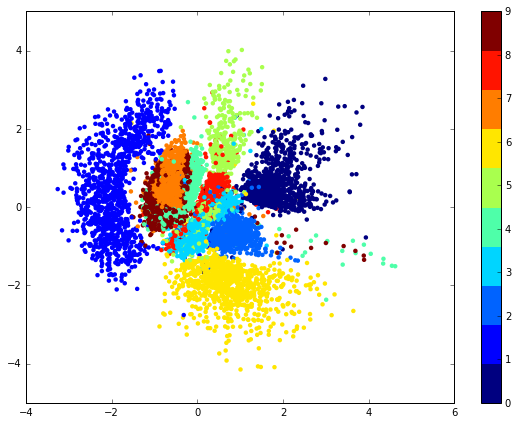

In [110]:
z = get_output(net['Z'], deterministic=True)
test_fun = theano.function([input_var], z)

batch_size = 100
num_test_batches = X_test.shape[0] // batch_size
test_batches = batch_generator(X_test, batch_size, shuffle=False)
    
prediction = []
for index in range(num_test_batches):
    prediction.append(test_fun(next(test_batches)))
    
prediction = np.array(prediction).reshape([-1,2])

plt.figure(figsize=(8, 6)) 
plt.scatter(prediction[:,0], prediction[:,1], c=y_test, cmap=plt.cm.get_cmap("jet", 10),  edgecolor='none')
plt.colorbar()

(-0.5, 559.5, 559.5, -0.5)

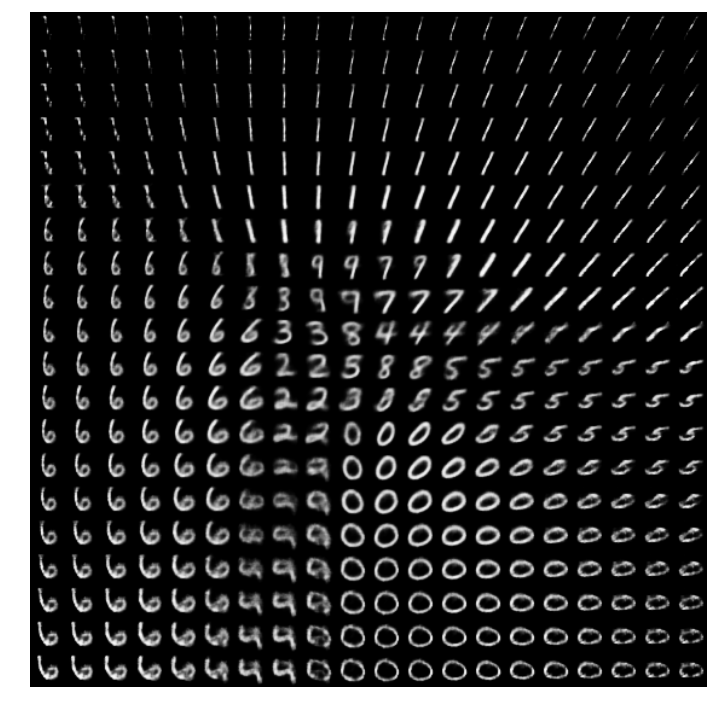

In [111]:
z_var = T.vector()
generated_x = get_output(net['X'], {net['encode_mu']:z_var}, 
            deterministic=True)
gen_fn = theano.function([z_var], generated_x)

num_grid = 20
width = 28
height = 28
tile_img = np.zeros((width*num_grid,height*num_grid))
MIN = np.min(prediction)
MAX = np.max(prediction)
pos = np.linspace(MIN,MAX,num_grid)
for i in range(num_grid):
    for j in range(num_grid):
        z = np.asarray([pos[i], pos[j]], dtype=theano.config.floatX)
        x_gen = gen_fn(z).reshape(-1, 1, width, height)
        tile_img[i*height:(i+1)*height, j*width:(j+1)*width] = x_gen
        
plt.figure(figsize=(10, 10))
plt.imshow(tile_img, cmap='gray')
plt.axis('off')

# MNIST 

In [4]:
# load mnist data
fname = '/home/peter/Data/mnist/mnist.pkl.gz'
f = gzip.open(fname, 'rb')
train_set, valid_set, test_set = pickle.load(f)
f.close()
X_train, y_train = train_set
X_valid, y_valid = valid_set
X_test, y_test = test_set

num_labels = 10
num_train = len(y_train)
num_valid = len(y_valid)
num_test = len(y_test)
X_train = X_train.reshape([-1,1,28,28])

In [5]:
class VariationalSampleLayer(layers.MergeLayer):
    def __init__(self, incoming_mu, incoming_logsigma, **kwargs):
        super(VariationalSampleLayer, self).__init__(incomings=[incoming_mu, incoming_logsigma], **kwargs)
        self.srng = RandomStreams(seed=234)

    def get_output_shape_for(self, input_shapes):
        return input_shapes[0]

    def get_output_for(self, inputs, deterministic=False, **kwargs):
        mu, logsigma = inputs
        shape=(self.input_shapes[0][0] or inputs[0].shape[0],
                self.input_shapes[0][1] or inputs[0].shape[1])
        if deterministic:
            return mu
        return mu + T.exp(logsigma) * self.srng.normal(shape, avg=0.0, std=1).astype(theano.config.floatX)


In [93]:
num_encode=2
num_units=500
x_dim = 28*28

input_var = T.tensor4('inputs')
net = {}
net['input'] = layers.InputLayer(shape=(None,1,28,28), input_var=input_var)
net['conv1'] = layers.Conv2DLayer(net['input'],  num_filters=25,
                                  filter_size=(5,5),
                                  W=init.GlorotUniform(),
                                  b=None, 
                                  pad='same')

net['conv1_bias'] = layers.BiasLayer(net['conv1'], b=init.Constant(0.05))
net['conv1_norm'] = layers.BatchNormLayer(net['conv1_bias'])
net['conv1_active'] = layers.NonlinearityLayer(net['conv1_norm'],nonlinearity=nonlinearities.rectify) 
net['conv1_pool'] = layers.MaxPool2DLayer(net['conv1_active'], pool_size=(2,2))

net['conv2'] = layers.Conv2DLayer(net['conv1_pool'],  num_filters=50,
                                  filter_size=(3,3),
                                  W=init.GlorotUniform(),
                                  b=None, 
                                  pad='same')
net['conv2_bias'] = layers.BiasLayer(net['conv2'], b=init.Constant(0.05))
net['conv2_norm'] = layers.BatchNormLayer(net['conv2_bias'])
net['conv2_active'] = layers.NonlinearityLayer(net['conv2_norm'],nonlinearity=nonlinearities.rectify)                          
net['conv2_pool'] = layers.MaxPool2DLayer(net['conv2_active'], pool_size=(2,2))
                                            
         
net['dense1'] = layers.DenseLayer(net['conv2_pool'], num_units=100, W=init.GlorotUniform(), 
                                  b=init.Constant(.0), nonlinearity=nonlinearities.rectify)
net['dense2'] = layers.DenseLayer(net['dense1'], num_units=100, W=init.GlorotUniform(), 
                                  b=init.Constant(.0), nonlinearity=nonlinearities.rectify)
                                  
net['encode_mu'] = layers.DenseLayer(net['dense2'], num_units=num_encode, W=init.GlorotUniform(), 
                                  b=init.Constant(.0), nonlinearity=nonlinearities.linear)
net['encode_logsigma'] = layers.DenseLayer(net['dense2'], num_units=num_encode, W=init.GlorotUniform(), 
                                  b=init.Constant(.0), nonlinearity=nonlinearities.linear)
net['Z'] = VariationalSampleLayer(net['encode_mu'], net['encode_logsigma'])
                                  
net['invline'] = layers.DenseLayer(net['Z'], num_units=net['dense2'].input_shape[1], W=init.GlorotUniform(), 
                                  b=init.Constant(.0), nonlinearity=nonlinearities.linear)
net['invdense2'] = layers.DenseLayer(net['invline'], num_units=net['dense2'].input_shape[1], W=net['dense2'].W.dimshuffle([1,0]), 
                                  b=init.Constant(.0), nonlinearity=nonlinearities.rectify)
num_units = np.prod(list(net['dense1'].input_shape)[1:])
net['invdense1'] = layers.DenseLayer(net['invdense2'], num_units=num_units, W=net['dense1'].W.dimshuffle([1,0]), 
                                  b=init.Constant(.0), nonlinearity=nonlinearities.rectify)
shape = list(get_output_shape(net['conv2_pool']))
shape[0] = -1
net['reshape'] = layers.ReshapeLayer(net['invdense1'], shape=tuple(shape))

net['invpool2'] = layers.Upscale2DLayer(net['reshape'], (2,2))
net['invconv2']  = Conv2DLayer(net['invpool2'], num_filters=net['conv2'].input_shape[1],
                                          filter_size=net['conv2'].filter_size,
                                          W=net['conv2'].W.dimshuffle([1,0,2,3]), #W2_inv, #
                                          b=init.Constant(0.05), 
                                          pad='same',
                                          nonlinearity=nonlinearities.rectify, flip_filters=True)


net['invpool1'] = layers.Upscale2DLayer(net['invconv2'], (2,2))
net['X']  = Conv2DLayer(net['invpool1'], num_filters=net['conv1'].input_shape[1],
                                          filter_size=net['conv1'].filter_size,
                                          W=net['conv1'].W.dimshuffle([1,0,2,3]), #W2_inv, #
                                          b=init.Constant(0.05), 
                                          pad='same',
                                          nonlinearity=nonlinearities.sigmoid, flip_filters=True)

In [101]:
def build_loss(net, target_var, deterministic):
    
    z_mu = get_output(net['encode_mu'], deterministic=deterministic)
    z_logsigma = get_output(net['encode_logsigma'], deterministic=deterministic)
    kl_divergence = 0.5*T.sum(1 + 2*z_logsigma - T.sqr(z_mu) - T.exp(2*z_logsigma), axis=1)
    
    x_mu = get_output(net['X'], deterministic=deterministic)
    x_mu = T.clip(x_mu, 1e-7, 1-1e-7)
    
    num_data = target_var.shape[0]
    target_var = target_var.reshape([num_data,-1])
    x_mu = x_mu.reshape([num_data, -1])
    log_likelihood = T.sum(target_var*T.log(1e-10+x_mu) + (1.0-target_var)*T.log(1e-10+1.0-x_mu), axis=1)
    variational_lower_bound = -log_likelihood - kl_divergence
    prediction = x_mu
    return variational_lower_bound.mean(), prediction

train_loss, train_prediction = build_loss(net, input_var, deterministic=False)

# ADAM updates
params = get_all_params(net['X'], trainable=True)
update_op = updates.adam(train_loss, params, learning_rate=1e-3)
train_fun = theano.function([input_var], train_loss, updates=update_op)

In [102]:
def batch_generator(X, batch_size=128, shuffle=True):
    if shuffle:
        indices = np.arange(len(X))
        np.random.shuffle(indices)
    for start_idx in range(0, len(X)-batch_size+1, batch_size):
        if shuffle:
            excerpt = indices[start_idx:start_idx+batch_size]
        else:
            excerpt = slice(start_idx, start_idx+batch_size)
        yield X[excerpt].astype(np.float32)
        
num_epochs = 60
batch_size = 100
num_train_batches = X_train.shape[0] // batch_size
    
for epoch in range(num_epochs):
    train_batches = batch_generator(X_train, batch_size, shuffle=True)

    train_loss = 0
    for index in range(num_train_batches):
        loss = train_fun(next(train_batches))
        train_loss += loss
        
    print("Epoch {} of {}".format(epoch+1, num_epochs))
    print("  training loss:\t\t{:.6f}".format(train_loss/num_train_batches))

Epoch 1 of 60
  training loss:		192.801668
Epoch 2 of 60
  training loss:		161.926330
Epoch 3 of 60
  training loss:		156.557744
Epoch 4 of 60
  training loss:		153.836412
Epoch 5 of 60
  training loss:		151.999493
Epoch 6 of 60
  training loss:		150.743028
Epoch 7 of 60
  training loss:		149.484530
Epoch 8 of 60
  training loss:		148.552518
Epoch 9 of 60
  training loss:		147.453246
Epoch 10 of 60
  training loss:		146.976031
Epoch 11 of 60
  training loss:		146.262802
Epoch 12 of 60
  training loss:		145.656219
Epoch 13 of 60
  training loss:		145.149565
Epoch 14 of 60
  training loss:		144.572306
Epoch 15 of 60
  training loss:		144.176642
Epoch 16 of 60
  training loss:		143.905554
Epoch 17 of 60
  training loss:		143.906687
Epoch 18 of 60
  training loss:		143.538557
Epoch 19 of 60
  training loss:		143.088910
Epoch 20 of 60
  training loss:		142.887293
Epoch 21 of 60
  training loss:		143.074270
Epoch 22 of 60
  training loss:		142.693736
Epoch 23 of 60
  training loss:		142.2393

KeyboardInterrupt: 

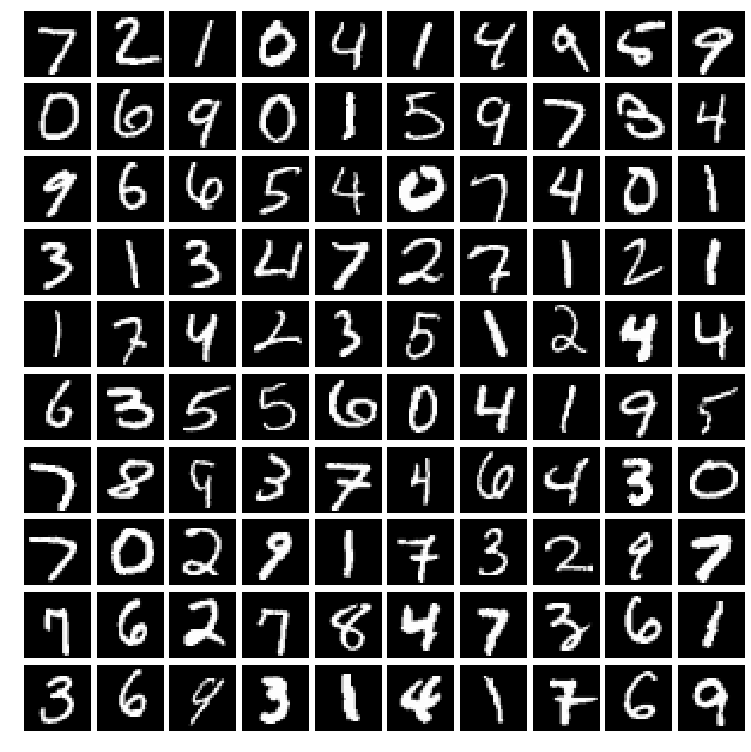

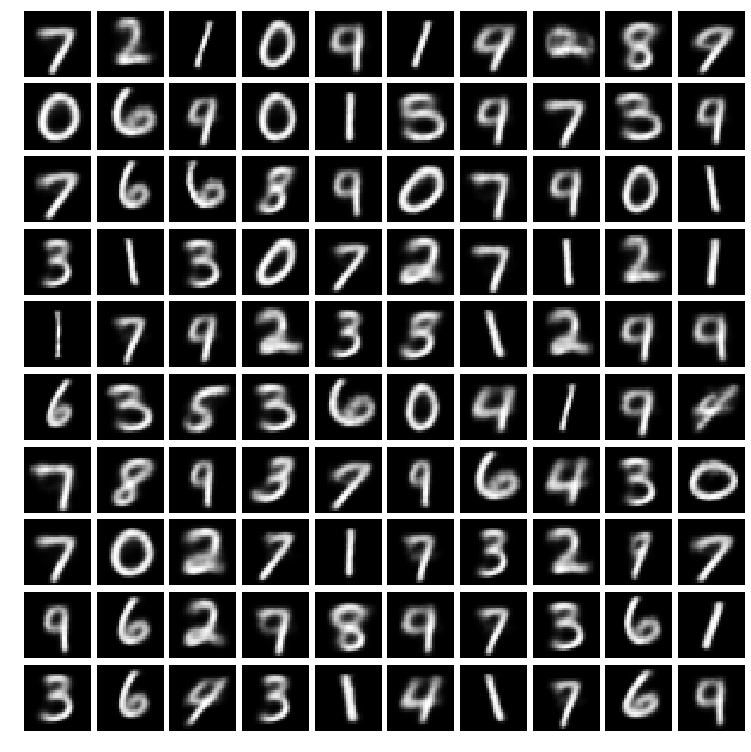

In [109]:
# save some example pictures so we can see what it's done 
example_batch_size = 100
X_comp = X_test[:example_batch_size]
X_comp = X_comp.reshape([-1,1,28,28])
pred_fn = theano.function([input_var], get_output(net['X'], deterministic=True))
X_pred = pred_fn(X_comp)

width = 10
height = 10

plt.figure(figsize = (height,width))
fig = plt.gcf()
fig.set_size_inches(100, 100, forward=True)
gs = mpl.gridspec.GridSpec(height, width)
gs.update(wspace=0.1, hspace=0.1, left=0.1, right=0.2, bottom=0.1, top=0.2) 
for i in range(width*height):
    img = np.reshape(X_comp[i], [28,28])
    plt.subplot(gs[i])
    plt.imshow(np.squeeze(img), cmap='gray', interpolation='nearest')
    plt.axis('off')
plt.show()



plt.figure(figsize = (height,width))
fig = plt.gcf()
fig.set_size_inches(100, 100, forward=True)
gs = mpl.gridspec.GridSpec(height, width)
gs.update(wspace=0.1, hspace=0.1, left=0.1, right=0.2, bottom=0.1, top=0.2) 
for i in range(width*height):
    img = np.reshape(X_pred[i], [28,28])
    plt.subplot(gs[i])
    plt.imshow(np.squeeze(img), cmap='gray', interpolation='nearest')
    plt.axis('off')
plt.show()


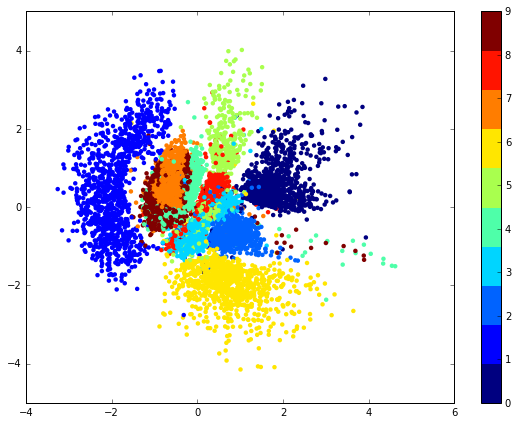

In [110]:
z = get_output(net['Z'], deterministic=True)
test_fun = theano.function([input_var], z)

batch_size = 100
num_test_batches = X_test.shape[0] // batch_size
test_batches = batch_generator(X_test.reshape([-1,1,28,28]), batch_size, shuffle=False)
    
prediction = []
for index in range(num_test_batches):
    prediction.append(test_fun(next(test_batches)))
    
prediction = np.array(prediction).reshape([-1,2])

plt.figure(figsize=(8, 6)) 
plt.scatter(prediction[:,0], prediction[:,1], c=y_test, cmap=plt.cm.get_cmap("jet", 10),  edgecolor='none')
plt.colorbar()

(-0.5, 559.5, 559.5, -0.5)

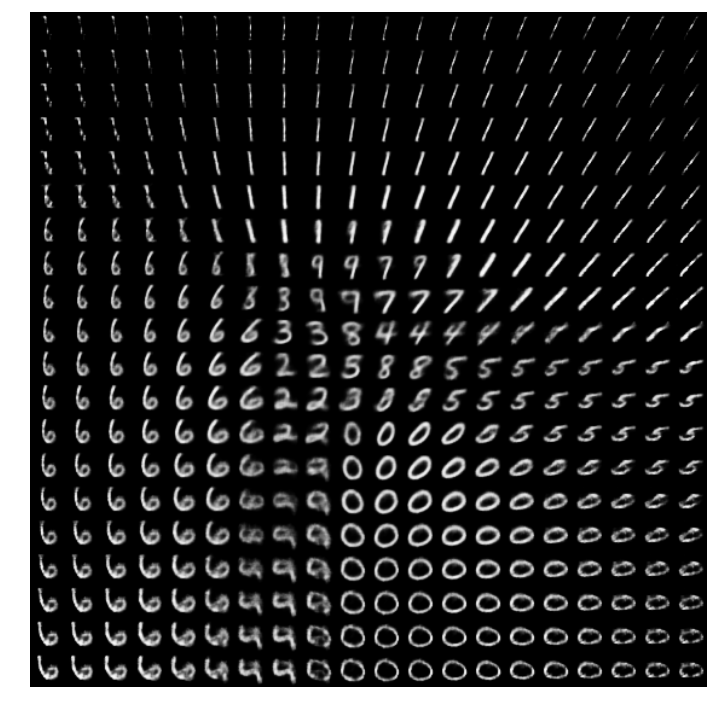

In [111]:
z_var = T.vector()
generated_x = get_output(net['X'], {net['encode_mu']:z_var}, 
            deterministic=True)
gen_fn = theano.function([z_var], generated_x)

num_grid = 20
width = 28
height = 28
tile_img = np.zeros((width*num_grid,height*num_grid))
MIN = np.min(prediction)
MAX = np.max(prediction)
pos = np.linspace(MIN,MAX,num_grid)
for i in range(num_grid):
    for j in range(num_grid):
        z = np.asarray([pos[i], pos[j]], dtype=theano.config.floatX)
        x_gen = gen_fn(z).reshape(-1, 1, width, height)
        tile_img[i*height:(i+1)*height, j*width:(j+1)*width] = x_gen
        
plt.figure(figsize=(10, 10))
plt.imshow(tile_img, cmap='gray')
plt.axis('off')